# Munich Bicycle Data - Cleaned

This jupyter notebook cleanes and normalizes raw data from the munich bicycle tracking stations.


It performs the following steps:

* Load all daily data csv files into one dataframe
* Merge the counting stations ("Zaehlstellen") information into the dataframe (for easier handling)
* Fix data/format inconsistencies, transform and deduplicate the data
* Save the data as json lines for further processing

This jupyter notebook requires the download of the raw data before proceeding with the notebook.

Please execute:

```
cd raw
python3 download_raw.py
```


## Documentation of input data

You find a detailed documentation of the input data source in the **README.md** in this folder.

This is the most relevant overview:

* The API offers metadata in json format
* The metadata contains links to csv files
* There are csv files with the counting data per day and per 15 minute intervals
* There is an extra csv file with information about the counting stations
* The csv files with the daily counts also contain weather information

## Cleaning the input data

### Bicycle Counting Stations

In [1]:
import glob
import pandas

# increase output width to be able to read all "besonderheiten" (special cases)
pandas.options.display.max_colwidth = 300

# Read the counting stations csv
counting_stations_csv = glob.glob("./raw/*radzaehlstellen.csv")[0]
df_counting_stations = pandas.read_csv(counting_stations_csv)
df_counting_stations

,zaehlstelle,zaehlstelle_lang,latitude,longitude,richtung_1,richtung_2,besonderheiten
0,Arnulf,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.
1,Kreuther,Bad-Kreuther-Str.,48.12194,11.62417,West,Ost,"Im April 2020 wurde die Zählschleife am Joseph-Hörwick-Weg auf den gesamten Querschnitt des Fuß- und Radweges ausgeweitet. Die Breite der Zählschleife hat sich dadurch in etwa verdoppelt. Bitte beachten Sie, dass Veränderungen in den Zahlen ab dem 1. April 2020 darauf zurückzuführen sind."
2,Olympia,Rudolf-Harbig-Weg (Olympia Park),48.16887,11.55005,Nord,Süd,NaN
3,Hirsch,Birketweg HLP (Hirschgarten),48.14438,11.51794,West,Ost,NaN
4,Margareten,Margaretenstr. (Harras),48.12032,11.53599,West,Ost,NaN
5,Erhardt,Erhardtstr. (Deutsches Museum),48.13192,11.58469,Süd,Nord,Es wird auf dem Fahrradweg als auch auf dem Fußweg gezählt.


## Daily Data

We are only interested in the daily data for our project. The data contains the following issues, which we will remove in the cleaning process:

* In some csv-files the min and max temperature columns are named `in.temp` and in others `in-temp` we unify this to `min-temp`
* Similarily there are the columns `max.temp` and `max-temp` which is unified to `max-temp`
* The column `besonderheiten` contains null values which are replaced with empty strings
* The datum column has different formats in different csvs (see _Correct date column_ for details)

In [2]:
import os

def read_all(glob_expression):
    """Reads all csv files selected by the glob expression and concatenates them into one single dataframe.
       Renames min.temp and max.temp columns so the column names match in all csv files."""
    
    data_csvs = glob.glob(glob_expression)
    
    dfs = []
    for data_csv in data_csvs:
        data = pandas.read_csv(data_csv)

        # Fix inconsistent temperature column names
        if 'min.temp' in data.columns:
            data = data.rename(columns={'min.temp': 'min-temp'})
        if 'max.temp' in data.columns:
            data = data.rename(columns={'max.temp': 'max-temp'})

        # Add the source filename for easier debugging
        data['datei'] = os.path.basename(data_csv)
        dfs.append(data)
    df_all_data = pandas.concat(dfs, ignore_index=True)
    return df_all_data

# Read all csv files and merge them into one dataframe, then merge the counting stations
df_daily_data = read_all("raw/*rad*tage*.csv")
df_daily_data = df_daily_data.merge(df_counting_stations, on='zaehlstelle')

# Replace null values in "besonderheiten" column with empty strings
df_daily_data['besonderheiten'] = df_daily_data['besonderheiten'].fillna('')

In [3]:
# Peek into dataframe after basic load
df_daily_data.head(3)

,datum,uhrzeit_start,uhrzeit_ende,zaehlstelle,richtung_1_x,richtung_2_x,gesamt,min-temp,max-temp,niederschlag,bewoelkung,sonnenstunden,datei,zaehlstelle_lang,latitude,longitude,richtung_1_y,richtung_2_y,besonderheiten
0,2017.03.01,00:00:00,23.59,Arnulf,742,52,794,1.4,8.1,3.9,85,1.4,daten-der-raddauerzaehlstellen-muenchen-maerz-2017-c9af32b1-fc32-4099-be51-4df58a577919-rad201703tage.csv,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.
1,2017.03.02,00:00:00,23.59,Arnulf,706,72,778,3.4,10.7,0.1,58,4.2,daten-der-raddauerzaehlstellen-muenchen-maerz-2017-c9af32b1-fc32-4099-be51-4df58a577919-rad201703tage.csv,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.
2,2017.03.03,00:00:00,23.59,Arnulf,921,73,994,1.0,13.1,0.0,75,4.6,daten-der-raddauerzaehlstellen-muenchen-maerz-2017-c9af32b1-fc32-4099-be51-4df58a577919-rad201703tage.csv,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.


### Correct date column

There 3 different date formats in the csv files:

* 01.05.2022 (%d.%m.%Y) German format
* 2022.05.01 (%Y.%m.%d) ISO format with dots instead of dashes
* 2022-05-01 (%Y-%m-%d) ISO format

We convert this all into iso format

In [4]:
# The date format in most columns is 2017.03.03 meaning '%Y.%m.%d', but there a couple of ones
# which don't match the format, so this throws exceptions
# df_daily_data['datum'] = pandas.to_datetime(df_daily_data['datum'], format='%Y.%m.%d')
#   ValueError: time data "01.05.2022" at position 793 doesn't match format specified
from re import match

ISO_FORMAT_REGEX = '^[0-9]{4}-[0-9]{2}-[0-9]{2}'
GERMAN_FORMAT_REGEX = '^([0-9]{2})\.([0-9]{2})\.([0-9]{4})$'

def reformat_date(input_data):
    """Reformats a date string into iso format, input can be german date format or iso format with
       dots. Plain isoformat can also be passed in, but won't be changed."""
    groups = match(GERMAN_FORMAT_REGEX, input_data)
    iso_format_with_dots = input_data
    
    # If the german format matches, then we reverse the order of the date groups
    if groups:
        iso_format_with_dots = groups.group(3) + "." + groups.group(2) + "." + groups.group(1)
    
    # Finally we replace the dots with dashes
    return iso_format_with_dots.replace(".", "-")

def print_non_iso_dates(df):
    """Prints all non iso dates in the dataframe."""
    matches = df['datum'].str.contains(ISO_FORMAT_REGEX, regex=True)
    non_matches = ~matches
    df_non_matching = df[non_matches]
    print(df_non_matching.count())
    
print_non_iso_dates(df_daily_data)

datum               14052
uhrzeit_start       14052
uhrzeit_ende        14052
zaehlstelle         14052
richtung_1_x        14052
richtung_2_x        14052
gesamt              14052
min-temp            14052
max-temp            14052
niederschlag        14052
bewoelkung          14052
sonnenstunden       14052
datei               14052
zaehlstelle_lang    14052
latitude            14052
longitude           14052
richtung_1_y        14052
richtung_2_y        14052
besonderheiten      14052
dtype: int64


In [5]:
df_daily_data['datum'] = df_daily_data['datum'].apply(reformat_date)

In [6]:
print_non_iso_dates(df_daily_data)

datum               0
uhrzeit_start       0
uhrzeit_ende        0
zaehlstelle         0
richtung_1_x        0
richtung_2_x        0
gesamt              0
min-temp            0
max-temp            0
niederschlag        0
bewoelkung          0
sonnenstunden       0
datei               0
zaehlstelle_lang    0
latitude            0
longitude           0
richtung_1_y        0
richtung_2_y        0
besonderheiten      0
dtype: int64


In [7]:
# Now as the dates are in uniform form we can convert the strings to datetime to get a nicer plot
df_daily_data['datum'] = pandas.to_datetime(df_daily_data['datum'], format='%Y-%m-%d')

# Clone the date column and use it as index
df_daily_data['datum_index'] = df_daily_data['datum']
df_daily_data = df_daily_data.set_index('datum_index')

# Drop not required uhrzeit (time) columns
df_daily_data = df_daily_data.drop(columns=['uhrzeit_start', 'uhrzeit_ende'])

# Unify float number formats
df_daily_data['min-temp'] = df_daily_data['min-temp'].astype(str).str.replace(',', '.').astype(float)
df_daily_data['max-temp'] = df_daily_data['max-temp'].astype(str).str.replace(',', '.').astype(float)
df_daily_data['niederschlag'] = df_daily_data['niederschlag'].astype(str).str.replace(',', '.').astype(float)
df_daily_data['sonnenstunden'] = df_daily_data['sonnenstunden'].astype(str).str.replace(',', '.').astype(float)

# Cast to correct types to allow deduplication
df_daily_data = df_daily_data.astype({
    'zaehlstelle': 'str',
    'richtung_1_x': 'int',
    'richtung_2_x': 'int',
    'gesamt': 'int',
    'min-temp': 'float',
    'max-temp': 'float',
    'niederschlag': 'float',
    'bewoelkung': 'float',
    'sonnenstunden': 'float',
    'datei': 'str',
    'zaehlstelle_lang': 'str',
    'latitude': 'float',
    'longitude': 'float',
    'richtung_1_y': 'str',
    'richtung_2_y': 'str',
    'besonderheiten': 'str'
})

# We don't want to check the datei (filename) column during deduplication, as this always will differ
columns_to_check = [col for col in df_daily_data.columns if col != 'datei']

df_daily_data = df_daily_data.drop_duplicates(columns_to_check)

In [8]:
# To drop duplicates with nan in min-temp we use
df_daily_data = df_daily_data.dropna(subset=['min-temp'])

# Now let's deduplicate the remaining days by keeping the ones with the highest "gesamt" value
df_daily_data = df_daily_data.sort_values('gesamt', ascending=False)
df_daily_data = df_daily_data.drop_duplicates(subset=["datum","zaehlstelle"], keep='first')

<Axes: xlabel='datum'>

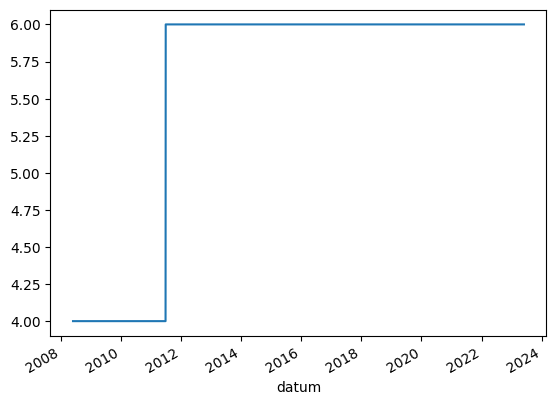

In [9]:
# Plot the number of entries per day, before 2012 there are only 4 counting stations
df_daily_data.datum.value_counts().plot()

In [10]:
# In the plot it looks like there are no exceptions, but let's query the dataset to be 100% sure
days_with_more_than_6_entries_per_day = df_daily_data.groupby('datum').filter(lambda x: len(x) > 6).index

assert len(days_with_more_than_6_entries_per_day) == 0

In [11]:
# Check for null values in the dataset
nans = df_daily_data.isnull().sum()
print(nans)

nan_count = df_daily_data.isnull().sum().sum()
assert nan_count == 0

print("\nNo NaN values found, all is fine")

datum               0
zaehlstelle         0
richtung_1_x        0
richtung_2_x        0
gesamt              0
min-temp            0
max-temp            0
niederschlag        0
bewoelkung          0
sonnenstunden       0
datei               0
zaehlstelle_lang    0
latitude            0
longitude           0
richtung_1_y        0
richtung_2_y        0
besonderheiten      0
dtype: int64

No NaN values found, all is fine


### Conclusion for daily data

After correcting the date format and parsing the date, we can see that the data is fine (one entry for every station on all days) and also our explicit check did not bring up any missing data.

**Daily data is fine without any further modifications**

In [12]:
df_daily_data = df_daily_data.sort_index()

filename = f'cleaned/bicycle-counting-station-daily.json'
df_daily_data.to_json(filename, orient='records', lines=True)